# Exercise 7 - Bagging and Boosting

In this exercise we will learn how to use an ensemble of weak learners to create a strong learner.
Bagging and Boosting will combine weak learners high variance and high bias respectively to a strong learner. 

In the event of a persistent problem, do not hesitate to contact the course instructor under

- paul.kahlmeyer@uni-jena.de

### Submission
- Deadline of submission:
        31.05.23 23:59
- Submission on [moodle page](https://moodle.uni-jena.de/course/view.php?id=43681)


### Help
In case you cannot solve a task, you can use the saved values within the `help` directory:
- Load arrays with [Numpy](https://numpy.org/doc/stable/reference/generated/numpy.load.html)
```
np.load('help/array_name.npy')
```
- Load functions with [Dill](https://dill.readthedocs.io/en/latest/dill.html)
```
import dill
with open('help/some_func.pkl', 'rb') as f:
    func = dill.load(f)
```

to continue working on the other tasks.

# Dataset

Similar to last exercise, we will use a synthetic dataset for binary classification created with scikit learn (see [here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)).

### Task 1

Load and display the data located in `X.npy` and `y.npy`.

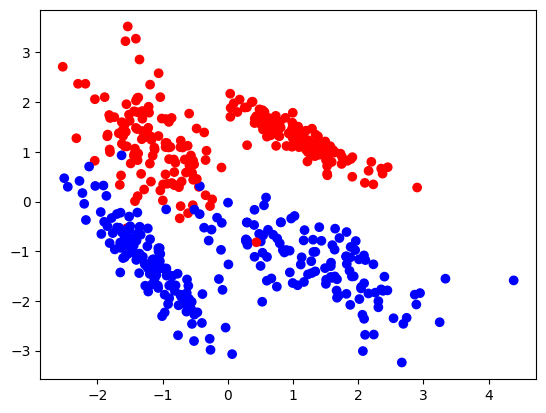

In [7]:
import matplotlib.pyplot as plt
# TODO: load and display data
import numpy as np
data_X = np.load("X.npy")
data_y = np.load("y.npy")

plt.scatter(data_X[:,0], data_X[:,1], c=data_y, cmap='bwr')

# Model

We will use decision trees as our model, since Bagging and Boosting have first been developed for these models. Note however that we could in principle replace the decision tree with any other classificator.

### Task 2

Use scikit learn to learn a decision tree on the dataset, calculate the accuracy and display the decision boundary (you can use `utils.py`).

('accuracy', 96.8, '%', 'score', 0.968)

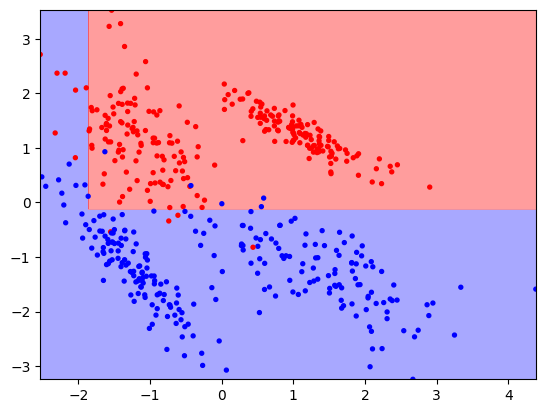

In [8]:
# TODO: learn decision tree
from sklearn.tree import DecisionTreeClassifier
import utils

dt = DecisionTreeClassifier(max_depth=2).fit(data_X, data_y)
# + print accuracy
accuracy = len(np.where(data_y == dt.predict(data_X))[0]) / len(data_y)
score = dt.score(data_X, data_y)

# + plot decision boundary
utils.plot_dec_boundary(data_X, data_y, dt)
"accuracy", accuracy * 100, "%", "score", score

# Crossvalidation

Until now, we used a train-test split of our data to evaluate how well a model generalizes on unseen data.
The test error is however greatly affected by the split. We could have a really bad split, where the test data is fundamentally different from the training data.

To overcome this issue, one typically uses **Crossvalidation** - a process where we average the performance of a model on the test data of multiple splits.

A commonly used procedure is called [**k-fold Crossvalidation**](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation):

1. Shuffle the dataset
2. Split the dataset into $k$ equal sized parts
3. For $i = 1,\dots,k$:\
    i) Use part $i$ as testdata, the other parts as trainingdata\
    ii) Train model on traindata\
    iii) Test model on testdata, save test score
4. Report all $k$ test scores


### Task 3

Implement the following cross validation function and evaluate the average crossvalidation score for the decision tree from Task 2 with $k = 10$.

In [9]:
def k_fold_cv(X : np.ndarray, y : np.ndarray, estimator, k : int, seed : int = 0) -> np.ndarray:
    '''
    Performs k-fold crossvalidation of an estimator.
    
    @Params:
        X... features
        y... labels
        estimator... object that has .fit(X,y), .predict(X) and .score(X,y) methods
        k... number of folds
        seed... for reproducibility
    
    @Returns:
        array with test scores for each of the k splits
    '''
    _length = X.shape[0]
    _block_size = np.floor(X.shape[0] / k)

    # _X = copy.deepcopy(X)
    # _y = copy.deepcopy(y)
    #
    # np.random.seed(seed)
    # np.random.shuffle(_X)
    #
    # np.random.seed(seed)
    # np.random.shuffle(_y)

    permutation = np.random.permutation(_length)
    _X = X[permutation]
    _y = y[permutation]

    scores = []

    for i in range(k):
        _mask = np.array([True if i*_block_size <= j < (i+1)*_block_size else False for j in range(_length)])

        _test_X = _X[_mask]
        _test_y = _y[_mask]

        _train_X = _X[~_mask]
        _train_y = _y[~_mask]

        estimator.fit(_train_X, _train_y)
        scores.append(estimator.score(_train_X, _train_y))

    return scores

# TODO: calculate avg. CV score for k = 10
dt2 = DecisionTreeClassifier(max_depth=2)
scores = k_fold_cv(data_X, data_y, DecisionTreeClassifier(max_depth=2), 10)
"avg. CV score", np.mean(scores)

('avg. CV score', 0.9688888888888888)

### Task 4

In the following we want to use scikit learn to perform crossvalidation.

Use scikit learns [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function to perform a 10-fold crossvalidation, similar to Task 3.
Again report the average crossvalidation score.


In [10]:
# TODO: calculate crossvalidation scores with sklearn
from sklearn.model_selection import cross_val_score

scores2 = cross_val_score(DecisionTreeClassifier(max_depth=2), data_X, data_y, cv=10)
"avg. score", np.mean(scores2)

('avg. score', 0.952)

# Bagging - Variance Reduction

In Bagging we have learners with **high variance**. 

<div>
<img src="images/bagging.png" width="700"/>
</div>

The idea is now to learn multiple of these weak learners **in parallel** and use an aggregated decision from all learners for prediction. The hope is that this way the ensemble can overthrow the overfit of a single learner.

## Bootstrapping

Since we would get the same learner each time if we learn on the same data, each learner is trained on a **bootstrap** dataset.

The idea is simple: Draw samples at random from the original dataset.

### Task 5

Implement the bootstrap function. Use it to sample a bootstrap dataset and display the densities of the original and bootstrap data. You can use `utils.plot_density` or create your own visualization.

IndexError: index 10 is out of bounds for axis 0 with size 10

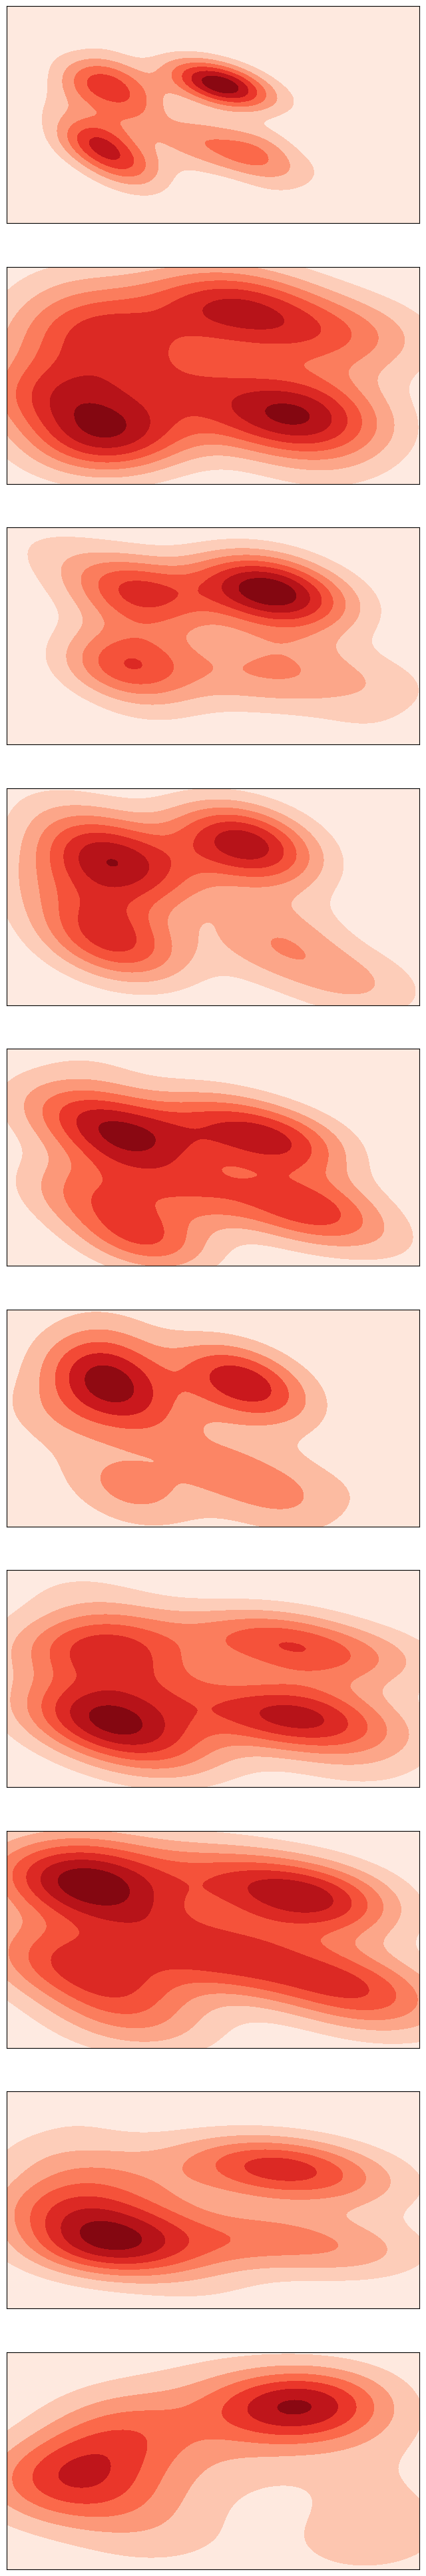

In [13]:
def sample_bootstrap(X : np.ndarray, y : np.ndarray, n_samples : int) -> tuple:
    '''
    Creates a bootstrap dataset.
    
    @Params:
        X... features
        y... labels
        n_samples... number of samples in bootstrap dataset
        
    @Returns:
        X, y of bootstrap dataset
    '''
    # TODO: implement
    _length = X.shape[0]
    permutation = np.random.permutation(_length)
    _X = X[permutation]
    _y = y[permutation]
    _block_size = np.floor(X.shape[0] / n_samples)

    bootstrap = []
    for i in range(n_samples):
        _mask = np.array([True if i*_block_size <= j < (i+1)*_block_size else False for j in range(_length)])
        bootstrap.append((_X[_mask], y[_mask]))

    return bootstrap

bs = sample_bootstrap(data_X, data_y, 10)
N = len(bs)
bs.insert(0, (data_X, data_y))
fig, ax = plt.subplots(N, 1, figsize=(8,50))
# TODO: draw bootstrap dataset
# TODO: visualize distribution of bootstrap and original data
for i, _bs in enumerate(bs):
    _X = _bs[0]
    _y = _bs[1]
    # print(_X, _y)
    utils.plot_density(_X, np.max(_X, axis=0), np.min(_X, axis=0), ax[i])


## Bootstrap Aggregation

Bagging now involves the two steps:

1. **Training**: Train $k$ learners on bootstrapped datasets (with the same size as the original dataset).
2. **Prediction**: Output the class label that most of the $k$ learners predict (majority vote).

### Task 6

Implement the Bagging class for decision trees. 

Use scikit learn to compute the crossvalidation scores ($k = 10$) for Bagging with 10 decision trees and maximum depth of 10.


**Note**:
- remember to empty the tree list for each fit. Otherwise crossvalidation will always append to this list.
- in order to use your own class in `cross_val_score` just inherit from `sklearn.base.BaseEstimator` and implement `fit` and `score`.

In [ ]:
from sklearn.base import BaseEstimator

class DecisionTreeBagging(BaseEstimator):
    
    def __init__(self, n_trees : int, max_depth : int):
        '''
        @Params:
            n_trees... number of decision trees in ensemble
            max_depth... maximum_depth of decision trees
        '''
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.trees = []
        
    def fit(self, X : np.ndarray, y : np.ndarray):
        '''
        Learns ensemble of decision trees with Bagging.
        
        @Params:
            X... features
            y... labels
        '''
        # TODO: implement
        pass
    
    def predict(self, X : np.ndarray) -> np.ndarray:
        '''
        Given features, predicts labels.
        
        @Params:
            X... features
            
        @Returns:
            labels as array
        '''
        # TODO: implement
        pass
    
    
    def score(self, X, y):
        '''
        Accuracy. 
        Needed for crossvalidation.
        
        @Params:
            X... features
            y... labels
            
        @Returns:
            Accuracy when predicting for X.
        '''
        # TODO: implement
        pass
    
# TODO: crossvalidation 10 trees, max_depth 10, k = 10

### Task 7

For an increasing number of trees in the ensemble, track the average crossvalidation score over 10 tries.

Again, use $k = 10$ folds and a maximum depth of 10.

In [ ]:
# TODO: increase number of trees, track avg. CV score over 10 tries

# Boosting - Bias Reduction

In Boosting we have learners with **high bias**. 

<div>
<img src="images/boosting.png" width="700"/>
</div>

The idea is here to learn multiple of these weak learners **in sequence** and use an aggregated decision from all learners for prediction. Each learner learns on data where the previous learner failed. The hope is that this way we can get finer decisions.

### Task 8

Use scikit learn to learn a decision tree with high bias on the data. Again display the decision boundary.

In [ ]:
# TODO: learn decision tree with high bias

## Weighted Samples

Each learner $L_{k}$ assigns different importance to samples depending on its predecessor learner $L_{k-1}$. This importance is realized by assigning a weight to each sample.

Let $L$ be a learner and $w$ be the vector of weights for each sample.

Then we define the weighted accuracy as 
\begin{align}
\text{Acc}_w = \cfrac{\sum_{i=1}^m w_i\cdot \mathbb{1}[L(x_i)=y_i]}{\sum_{i=1}^m wi}\,,
\end{align}
where $\mathbb{1}$ is the indicator function.

### Task 9

Implement the following function and calculate the weighted accuracy for the decision tree from task 8 if we assume equal weights for each sample.

In [ ]:
def weighted_acc(X : np.ndarray, y : np.ndarray, estimator, weights : np.ndarray) -> float:
    '''
    Calculates weighted accuracy.
    
    @Params:
        X... features
        y... labels
        estimator... object with .predict function
        weights... weights for each x in X
    
    @Returns:
        weighted accuracy
    '''
    # TODO: implement
    pass


# TODO: calculate weighted accuracy

## Importance of say

Learners with high accuracy should have more say in the final decision.

The so called **importance of say** is defined as:
\begin{align*}
\alpha = \log\left(\cfrac{\text{Acc}_w}{1 - \text{Acc}_w}\right)\,.
\end{align*}

### Task 10

Implement the following function and calculate the importance of say of the decision tree on the dataset with equal weights.

Make sure the function does not fail in the extreme cases $\text{Acc}_w = 0$ and $\text{Acc}_w = 1$.

In [ ]:
def imp_of_say(X, y, estimator, weights):
    '''
    Calculates weighted accuracy.
    
    @Params:
        X... features
        y... labels
        estimator... object with .predict function
        weights... weights for each x in X
    
    @Returns:
        weighted accuracy
    '''
    # TODO: implement
    pass

# TODO: calculate importance of say

## Prediction

With the importance of say the ensemble of learners $L_1,\dots, L_k$ predicts a label based on the sign of the individual predictions (transformed into -1, 1 labels) weighted with the importance of say $\alpha$: 

\begin{align}
\hat{y}_i = \mathbb{1}\left[\left(\sum_k \alpha_k\cdot (2L_k(x_i) - 1)\right) > 0\right]
\end{align}

Note how an extremely low accuracy (worse than random with 0.5) will lead to a negative importance of say which will in turn invert the sign of the predicton. 

### Task 11

Use the calculated importance of say $\alpha$ from task 10 and predict the labels for the dataset.

Calculate the accuracy on these predictions and compare it to the accuracy of the decision tree (`.score`).

In [ ]:
# TODO: predict + compare accuracies

## Adjust weights

After a learner is done learning, we adjust the sample weights for the next learner. Roughly speaking, we want to increase the weights of misclassified samples, so the next learner only performs good if these critical samples are done right.

Let $L$ be the current learner with importance of say $\alpha$ and $w$ be the vector of weights. Then we update each entry $w_i$ with:

\begin{align}
w_i \rightarrow w_i\cdot\exp\left(\alpha\cdot\mathbb{1}[L(x_i) \neq y_i]\right)\,,
\end{align}
where $\mathbb{1}$ is the indicator function.

Note how:

- If we have a very good classifier, we have a large $\alpha$ and we increase the weight of misclassified samples drastically (so they finally get classified correctly with the next classifier)
- If we have a very bad classifier with large negative $\alpha$, we actually have a good classifier that just flips the labels wrong (systematic failure). We account for this with our prediction and can consider these samples well covered by this classifier. Hence we decrease the weight of these samples

The next learner now uses these weights to focus the training on samples with high weight.
This is done by learning on a bootstrap dataset which is draw **according to the weights**. Samples with high weight are drawn more often and hence the learner is more likely to focus on these samples.

### Task 12

Implement the weighted bootstrap sampling function.

Calculate the new weights and draw bootstrap samples according to the old, weights and the new, adjusted weights.

Similar to task 5, display the densities of the original and bootstrapped data.

In [ ]:
def weighted_sample_bootstrap(X : np.ndarray, y : np.ndarray, n_samples : int, weights : np.ndarray) -> tuple:
    '''
    Creates a weighted bootstrap dataset.
    
    @Params:
        X... features
        y... labels
        n_samples... number of samples in bootstrap dataset
        weights... weights for individual samples
    @Returns:
        X, y of bootstrap dataset
    '''
    # TODO: implement
    pass

# TODO: calculate new weights + sample bootstrap data

# TODO: plot densities

## Build boosted Ensemble 

Now we have everything to build a Boosted decision tree ensemble.
Starting with equal weights, we perform the following steps for each learner:

1. Bootstrap Dataset according to weights
2. Learn a weak learner
3. Score Performance $\rightarrow$ weight of learner
4. Adjust weights of samples


### Task 13

Implement the Boosting class for decision trees. 

Use scikit learn to compute the crossvalidation scores ($k = 10$) for Boosting with 10 decision trees and maximum depth of 1.

In [ ]:
from sklearn.base import BaseEstimator

class DecisionTreeBoosting(BaseEstimator):
    
    def __init__(self, n_trees : int, max_depth : int):
        '''
        @Params:
            n_trees... number of decision trees in ensemble
            max_depth... maximum_depth of decision trees
        '''
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.trees = []
        self.alphas = []
        
    def fit(self, X : np.ndarray, y : np.ndarray):
        '''
        Learns ensemble of decision trees with Bagging.
        
        @Params:
            X... features
            y... labels
        '''
        # TODO: implement
        pass
        
        
    def predict(self, X : np.ndarray) -> np.ndarray:
        '''
        Given features, predicts labels.
        
        @Params:
            X... features
            
        @Returns:
            labels as array
        '''
        # TODO: implement
        pass
    
    def score(self, X, y):
        '''
        Accuracy. 
        Needed for crossvalidation.
        
        @Params:
            X... features
            y... labels
            
        @Returns:
            Accuracy when predicting for X.
        '''
        # TODO: implement
        pass
    
# TODO: crossvalidation 10 trees, max_depth 10, k = 10

### Task 14

Similar to task 7, track the average crossvalidation score over 10 tries for an increasing number of trees in the ensemble.

Use $k = 10$ folds and a maximum depth of 1.

In [ ]:
# TODO: increase number of trees, track avg. CV score over 10 tries